![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction](#introduction)
2. [Creating the planner](#planning)
3. [Simulating the planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

In [1]:
import os,sys
dir_current_file = os.path.dirname("/home/czf/git-paper/nuplan-2/nuplan-devkit/tutorials/nuplan_framework copy.ipynb")
sys.path.append(dir_current_file)
dir_parent_1 = os.path.dirname(dir_current_file)
sys.path.append(dir_parent_1)
dir_parent_2 = os.path.dirname(dir_parent_1)
sys.path.append(dir_parent_2)
dir_parent_3 = os.path.dirname(dir_parent_2)
sys.path.append(dir_parent_3)

from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

# Creating a new planner in nuPlan <a name="introduction"></a>


Welcome to the nuplan planning tutorial. One of the core interactions with nuplan will be to build and train your own planners and run them through nuplan's simulation pipeline for evaluation. While we discuss how to train your machine learned planners in other tutorials, in this tutorial we will show you the basic elements you will need for constructing a planner that plugs into the nuplan interface. We will also show you the basics of running the planner in simulation and visualizing the behavior and metrics for evaluation.

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [2]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML

display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_530043/911397167.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Creating the planner <a name="planning"></a>

The planner is the main component responsible for determining the ego vehicle's behavior. At it's core, a planner will consume state information in the form of observations regarding its own pose, poses of other agents, and various static and dynamic map information, along with a goal, and produce a trajectory dictating the future path that the ego vehicle will attempt to follow according to a given control strategy.

<img src="media/planner_inputs_outputs_diagram.drawio.svg"/>

In nuplan, all planners will inherit from the *AbstractPlanner* class and, along with whatever additional functionality you provide it, will have to implement a few core methods. Let's take a look at the *AbstractPlanner* class.

Let's take a look at these core methods one by one.

**initialize**: This method initializes the planner with important static information including the high level goal, represented as a (x, y, heading) pose, which in practice might be provided a higher level routing system, as well as the interface for interacting with relevant map information.

**name**: The name of the planner. This one's easy!

**observation_type**: This dictates what type of observations the planner will consume to inform it's decision making. Options here include *Sensors* (raw sensor information such as images or pointclouds) and *DetectionsTracks* (outputs of an earlier perception system designed to consume sensor information and produce meaningful detections).

**compute_trajectory**: This is the core behavior of the planner, and the part you will most likely spend the most time on. This method will consume a history buffer containing discretized past ego trajectory information as well as observations of the type declared in *observation_type* up until the current time step. Correctly accounting for historical as well as current information will allow the planner to produce more stable and strategic behaviors and avoid overcorrecting in the presence of noisy observations. The *compute_trajectory* method will be responsible for producing the trajectory dictating the path the ego vehicle will attempt to follow in the future. The trajectory represents the series of ego states (identifying pose along with dynamic information such as velocities and accelerations) the vehicle will try to attain along a specified time horizon, most easily represented as a list of states along with a method to interpolate between them.


We will now use the *SimplePlanner* class as an example of how to implement the *AbstractPlanner* interface with a real planner.

In [6]:
from typing import List, Type

import numpy as np
import numpy.typing as npt

from nuplan.common.actor_state.ego_state import DynamicCarState, EgoState
from nuplan.common.actor_state.state_representation import StateSE2, StateVector2D, TimePoint
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters, VehicleParameters
from nuplan.planning.simulation.observation.observation_type import DetectionsTracks, Observation
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner, PlannerInitialization, PlannerInput
from nuplan.planning.simulation.trajectory.interpolated_trajectory import  InterpolatedTrajectory
from nuplan.planning.simulation.trajectory.abstract_trajectory import AbstractTrajectory
from nuplan.planning.simulation.controller.motion_model.kinematic_bicycle import KinematicBicycleModel


class SimplePlanner(AbstractPlanner):
    """
    Planner going straight
    """

    def __init__(self,
                 horizon_seconds: float,
                 sampling_time: float,
                 acceleration: npt.NDArray[np.float32],
                 max_velocity: float = 5.0,
                 steering_angle: float = 0.0):
        self.horizon_seconds = TimePoint(int(horizon_seconds * 1e6))
        self.sampling_time = TimePoint(int(sampling_time * 1e6))
        self.acceleration = StateVector2D(acceleration[0], acceleration[1])
        self.max_velocity = max_velocity
        self.steering_angle = steering_angle
        self.vehicle = get_pacifica_parameters()
        self.motion_model = KinematicBicycleModel(self.vehicle)

    def initialize(self, initialization: List[PlannerInitialization]) -> None:
        """ Inherited, see superclass. """
        pass

    def name(self) -> str:
        """ Inherited, see superclass. """
        return self.__class__.__name__

    def observation_type(self) -> Type[Observation]:
        """ Inherited, see superclass. """
        return DetectionsTracks  # type: ignore

    def compute_planner_trajectory(self, current_input: PlannerInput) -> List[AbstractTrajectory]:
        """
        Implement a trajectory that goes straight.
        Inherited, see superclass.
        """
        # Extract iteration and history
        iteration = current_input.iteration
        history = current_input.history

        ego_state = history.ego_states[-1]
        state = EgoState(
            car_footprint=ego_state.car_footprint,
            dynamic_car_state=DynamicCarState.build_from_rear_axle(
                ego_state.car_footprint.rear_axle_to_center_dist,
                ego_state.dynamic_car_state.rear_axle_velocity_2d,
                self.acceleration,
            ),
            tire_steering_angle=self.steering_angle,
            is_in_auto_mode=True,
            time_point=ego_state.time_point,
        )
        trajectory: List[EgoState] = [state]
        for _ in np.arange(
            iteration.time_us + self.sampling_time.time_us,
            iteration.time_us + self.horizon_seconds.time_us,
            self.sampling_time.time_us,
        ):
            if state.dynamic_car_state.speed > self.max_velocity:
                accel = self.max_velocity - state.dynamic_car_state.speed
                state = EgoState.build_from_rear_axle(
                    rear_axle_pose=state.rear_axle,
                    rear_axle_velocity_2d=state.dynamic_car_state.rear_axle_velocity_2d,
                    rear_axle_acceleration_2d=StateVector2D(accel, 0),
                    tire_steering_angle=state.tire_steering_angle,
                    time_point=state.time_point,
                    vehicle_parameters=state.car_footprint.vehicle_parameters,
                    is_in_auto_mode=True,
                    angular_vel=state.dynamic_car_state.angular_velocity,
                    angular_accel=state.dynamic_car_state.angular_acceleration,
                )

            state = self.motion_model.propagate_state(state, state.dynamic_car_state, self.sampling_time)
            trajectory.append(state)

        return InterpolatedTrajectory(trajectory)

The *SimplePlanner* is very simple indeed, electing to just drive straight according to a specified steering angle. It doesn't even take into account the observations it receives!

The *initialize*, *name*, and *observation_type* methods are straightforward implementations of the *AbstractPlanner* interface. The observation type here is declared as *DetectionsTracks* for use with processed detections coming from the perception system, though we note that the observations are completely ignored in the *compute_trajectory* method (we would still want to change this to *Sensors* for use with raw sensor data such as lidar pointclouds). Furthermore, we note the additional *\_\_init\_\_* method that sets intrinsic parameters of the planner, such as what steering angle it will follow and by how much it will accelerate.

The *compute_trajectory* method applies the motion model of the car to update the current velocity profile with the straight line acceleration specified at initialization, rolling this out according to the horizon also specified at initialization. A more advanced planner would take the observation history and map into account and try to reach the goal specified at initialization.

# Simulating the planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Simulation parameters

### Ego Controller

Change the controller the ego vehicle uses to track the trajectory supplied by the planner (in the case of closed-loop) or whether log replay is used (open-loop) with `ego_controller=X` where `X` is a config yaml defined in the table below. 

| Ego controller | Description | Config |
| --- | --- | --- |
| Log play back controller | Open-loop simulation via log replay | `log_play_back_controller` |
| Perfect tracking controller | Ego perfectly tracks given trajectory (closed-loop) | `perfect_tracking_controller` |

### Observation

Change the type of observation supplied to the planner with `observation=X` where `X` is a config yaml defined in the table below. 

| Observation | Description | Config |
| --- | --- | --- |
| Box observation | Bounding boxes | `box_observation` |
| IDM agents observation | Smart agent detections | `idm_agents_observation` | 
|Lidar pc observation | Lidar point clouds from the scenario | `lidar_pc_observation` |

## Prepare the simulation config

In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts
SAVE_DIR = tempfile.mkdtemp()

NUPLAN_MAPS_ROOT = os.getenv("NUPLAN_MAPS_ROOT", "/home/czf/nuplan/dataset/maps")
NUPLAN_DB_FILES = os.getenv(
    "NUPLAN_DB_FILES", "/home/czf/nuplan/dataset/nuplan-v1.1/splits/mini"
)
NUPLAN_MAP_VERSION = os.getenv("NUPLAN_MAP_VERSION", "nuplan-maps-v1.0")
NUPLAN_DATA_ROOT = os.getenv("NUPLAN_DATA_ROOT", "/home/czf/nuplan/dataset")

# Select simulation parameters
# EGO_CONTROLLER = 'perfect_tracking_controller'  # [log_play_back_controller, perfect_tracking_controller]
EGO_CONTROLLER = "two_stage_controller"  # [log_play_back_controller, perfect_tracking_controller]
# OBSERVATION = 'box_observation'  # [box_observation, idm_agents_observation, lidar_pc_observation]
OBSERVATION = "idm_agents_observation"  # [box_observation, idm_agents_observation, lidar_pc_observation]
DATASET_PARAMS = [
    "scenario_builder=nuplan_mini",  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    "scenario_filter=one_continuous_log",  # simulate only one log
    "scenario_filter.log_names=['2021.07.16.20.45.29_veh-35_01095_01486']",
    "scenario_filter.limit_total_scenarios=2",  # use 2 total scenarios
]

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration

cfg = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        f"group={SAVE_DIR}",
        f"experiment_name=planner_tutorial",
        f"job_name=planner_tutorial",
        "experiment=${experiment_name}/${job_name}",
        "worker=sequential",
        f"ego_controller={EGO_CONTROLLER}",
        f"observation={OBSERVATION}",
        f"hydra.searchpath=[{simulation_hydra_paths.common_dir}, {simulation_hydra_paths.experiment_dir}]",
        "output_dir=${group}/${experiment}",
        *DATASET_PARAMS,
    ],
)
cfg.scenario_builder.data_root = "/home/czf/nuplan/dataset"
cfg.scenario_builder.map_root = "/home/czf/nuplan/dataset/maps"
cfg.scenario_builder.map_version = "nuplan-maps-v1.0"
# cfg.scenario_builder.snesor_root = "/home/czf/nuplan/dataset/nuplan-v1.1/sensor_blobs"
cfg.scenario_builder.db_files = "/home/czf/nuplan/dataset/nuplan-v1.1/splits/mini"

/tmp/ipykernel_530043/3772066751.py:33: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path=simulation_hydra_paths.config_path)
/home/czf/anaconda3/envs/nuplan/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'default_simulation': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


## Launch simulation (within the notebook)

/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/run_simulation.py:109: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=CONFIG_PATH, config_name=CONFIG_NAME)
Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-10-21 16:47:03,481 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-10-21 16:47:03,481 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2024-10-21 16:47:03,481 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 1
Number of GPUs per node: 0
Number of threads across all nodes: 1
2024-10-21 16:47:03,481 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-10-21 16:47:03,481 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-10-21 16:47:03,481 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	F

2024-10-21 16:47:29,416 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 2
2024-10-21 16:47:29,416 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2024-10-21 16:47:29,416 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-10-21 16:47:29,419 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /tmp/tmp2tmao_q1/planner_tutorial/planner_tutorial/runner_report.parquet
2024-10-21 16:47:29,420 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:00:25 [HH:MM:SS]
2024-10-21 16:47:29,426 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files int

Rendering histograms: 100%|██████████| 4/4 [00:00<00:00, 19.24it/s]


2024-10-21 16:47:29,881 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:00 [HH:MM:SS]
2024-10-21 16:47:29,881 INFO {/home/czf/git-paper/nuplan-2/nuplan-devkit/nuplan/planning/script/run_simulation.py:90}  Finished running simulation!


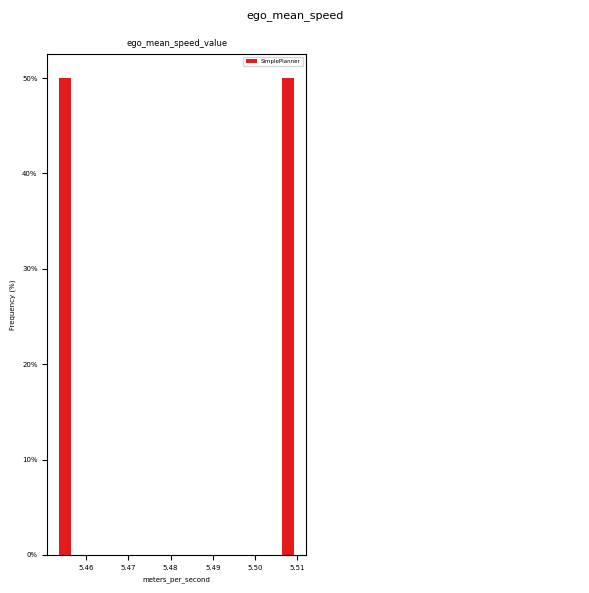

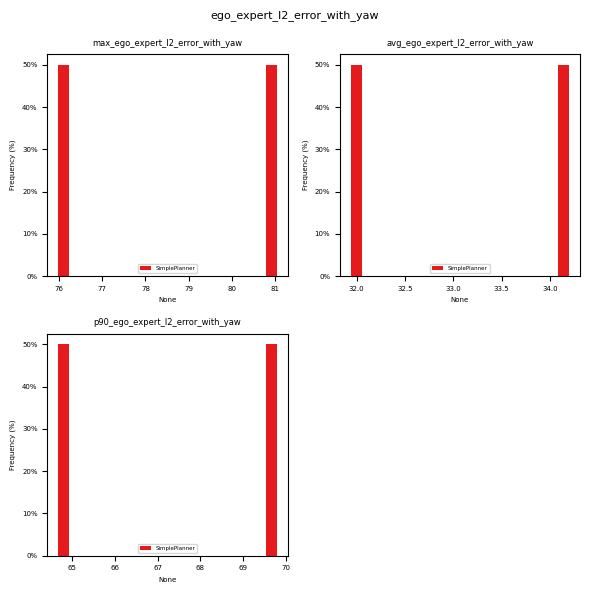

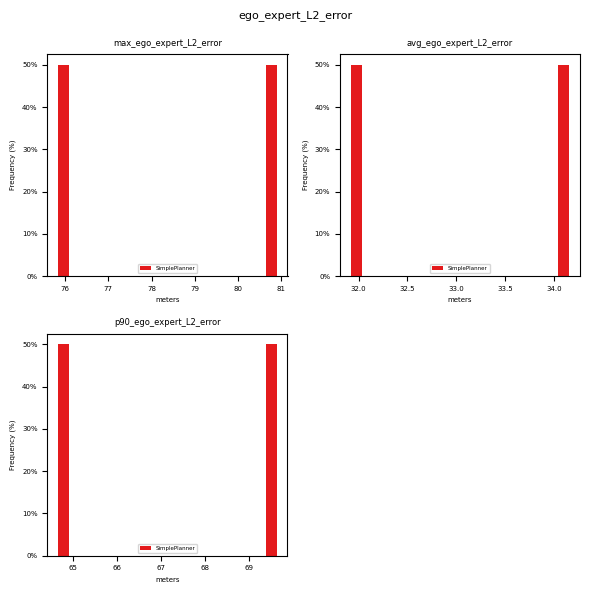

In [8]:
from nuplan.planning.script.run_simulation import run_simulation as main_simulation

planner = SimplePlanner(horizon_seconds=10.0, sampling_time=0.25, acceleration=[0.0, 0.0])

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg, planner)

In [15]:
# Get nuBoard simulation file for visualization later on
simulation_file = [str(file) for file in Path(cfg.output_dir).iterdir() if file.is_file() and file.suffix == '.nuboard']

# Visualizing metrics and scenarios  <a name="dashboard"></a>

## nuBoard summary

For visualization, we use nuBoard to evaluate the planner:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [9]:
from tutorials.utils.tutorial_utils import construct_nuboard_hydra_paths

# Location of paths with all nuBoard configs
nuboard_hydra_paths = construct_nuboard_hydra_paths(BASE_CONFIG_PATH)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=nuboard_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=nuboard_hydra_paths.config_name, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={simulation_file}',  # nuboard file path, if left empty the user can open the file inside nuBoard
    f'hydra.searchpath=[{nuboard_hydra_paths.common_dir}, {nuboard_hydra_paths.experiment_dir}]',
])
cfg.scenario_builder.map_root = "/home/czf/nuplan/dataset/maps"

/tmp/ipykernel_530043/1308142317.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path=nuboard_hydra_paths.config_path)


NameError: name 'simulation_file' is not defined

## Launch nuBoard (open in new tab)

In [1]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

ModuleNotFoundError: No module named 'nuplan'